In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import time
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.display.min_rows = 20

In [2]:
# Load the lab result - adt joined table
lradt = pd.read_pickle('data/lradt_20211025.pkl')

In [3]:
lradt.head(3)

,uid,anon_id,pat_enc_csn_id_coded,order_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type
0,13558775,JC1027715,318017820,734443153,1230100765,Lab,LAB141,"Uric Acid, Ser/Plas","Uric Acid, Ser/Plas",URIC,2.8,None,None,mg/dL,None,None,2018-02-10 00:00:00,2018-02-10 04:19:00,2018-02-09 23:59:00,Inpatient,10201250,Hematology/Oncology,Acute Care,Oncology Level 4,Inpatient,Inpatient,Census,Census,3735168,Census
1,14489712,JC1027715,318017820,736974182,302,Blood Bank,LAB488,Platelets,Issue Date/Time,PLTDI,9999999.0,None,None,None,None,None,2018-05-14 16:19:00,2018-05-15 07:15:00,2018-05-13 23:59:00,Inpatient,10201250,Oncology,Acute Care,Oncology Level 3,Inpatient,Inpatient,Census,Census,3993263,Census
2,14611060,JC1027715,318017820,737284976,313,Blood Bank,LAB488,Platelets,Unit Product ID,PLTPID,9999999.0,None,None,None,None,None,2018-05-26 09:37:00,2018-05-27 07:15:00,2018-05-25 23:59:00,Inpatient,10201250,Hematology/Oncology,Acute Care,Oncology Level 4,Inpatient,Inpatient,Census,Census,4028265,Census


In [4]:
print('Total number of rows:\t', len(lradt))
print('Total number of orders:\t', len(lradt.order_id_coded.unique()))

Total number of rows:	 4134067
Total number of orders:	 620729


In [5]:
print('Pruning labs that occurred on the last day\t')
lradt = lradt.loc[lradt.result_time < lradt.result_time.max()]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

Pruning labs that occurred on the last day	
Remaining number of rows:	 4101880
Remaining number of orders:	 616308


In [6]:
pd.DataFrame(lradt.order_type.value_counts())

,order_type
Lab,2596230
Lab Only - Beaker,853417
Point of Care Testing,235749
Blood Bank,144432
Point of Care Testing-Docked Device,136472
Microbiology,120373
ECG,15091
Nursing,116


In [7]:
# Look at group_lab_names in order to prune lab orders and combine similar lab concepts
pd.DataFrame(lradt.group_lab_name.value_counts()).to_csv('data/group_lab_name_counts.csv')

In [8]:
print('Pruning point of care labs...')
lradt = lradt.loc[(lradt.order_type!='Point of Care Testing-Docked Device') & (lradt.order_type!='Point of Care Testing')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning ECG orders...')
lradt = lradt.loc[(lradt.order_type!='ECG')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Blood Bank orders...')
lradt = lradt.loc[(lradt.order_type!='Blood Bank')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Nursing orders...')
lradt = lradt.loc[(lradt.order_type!='Nursing')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning iSTAT labs...')
lradt = lradt.loc[~lradt.group_lab_name.str.contains("ISTAT", case=False)]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Manual Differential/Slide Review Orders...')
lradt = lradt.loc[lradt.group_lab_name!='Manual Differential/Slide Review']
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

Pruning point of care labs...
Remaining number of rows:	 3729659
Remaining number of orders:	 544785

Pruning ECG orders...
Remaining number of rows:	 3714568
Remaining number of orders:	 542264

Pruning Blood Bank orders...
Remaining number of rows:	 3570136
Remaining number of orders:	 516968

Pruning Nursing orders...
Remaining number of rows:	 3570020
Remaining number of orders:	 516921

Pruning iSTAT labs...
Remaining number of rows:	 3569688
Remaining number of orders:	 516755

Pruning Manual Differential/Slide Review Orders...
Remaining number of rows:	 3426794
Remaining number of orders:	 502338


In [9]:
print('Earliest lab result datetime:\t', lradt.result_time.min())
print('Latest lab result datetime:\t', lradt.result_time.max())

Earliest lab result datetime:	 2014-04-04 13:28:00
Latest lab result datetime:	 2019-10-30 23:23:00


In [10]:
# Rename some group_lab_names that are the same
lradt['njr_labname'] = lradt['group_lab_name']
cbc =  ['CBC with Differential', 'CBC with Diff', 'CBC', 'CBC with Diff and Slide Review']
poct_urine = ['POCT Urine Dipstick (10)', 'POCT Urine Dipstick (9)']
poct_glucose = ['Glucose By Meter', 'Glucose PCX Meter']
lradt.loc[lradt.njr_labname.isin(cbc), 'njr_labname'] = 'CBC'
# lradt.loc[lradt.njr_labname.isin(poct_urine), 'njr_labname'] = 'POCT Urine'
# lradt.loc[lradt.njr_labname.isin(poct_glucose), 'njr_labname'] = 'POCT Glucose'

## Repetitive Lab Orders

In [11]:
# labcounts sorted by total number of orders
labcounts = lradt.groupby(by='njr_labname').agg({'order_id_coded': 'nunique', 'pat_enc_csn_id_coded': 'nunique', 'anon_id': 'nunique'}).rename(columns={'order_id_coded': 'norders', 'pat_enc_csn_id_coded': 'nenc', 'anon_id': 'npat'}).sort_values('norders', ascending=False)
labcounts['per_enc'] = labcounts.norders/labcounts.nenc
labcounts.head(20)

,norders,nenc,npat,per_enc
njr_labname,,,,
CBC,57600,16055,7751,3.587667
Chem 10,45595,9816,4401,4.644967
"Magnesium, Ser/Plas",31070,8219,4427,3.780265
Renal Function Panel,23946,5230,2919,4.578585
"Metabolic Panel, Comprehensive",16806,7689,4602,2.185720
Urinalysis Macroscopic Only,14030,2158,909,6.501390
Antibody Screen,12513,5706,2246,2.192955
ABO Rh Typing,12399,5643,2196,2.197236
"Tacrolimus Level, FK506",12083,2493,781,4.846771


In [12]:
# Labcounts sorted by labs per encounter for labs occurring in more than __ encounters
labcounts.loc[(labcounts.norders>5000) & (labcounts.nenc>500)].sort_values('per_enc', ascending=False).head(20)

,norders,nenc,npat,per_enc
njr_labname,,,,
"Uric Acid, Ser/Plas",9085,1030,853,8.820388
Urinalysis Macroscopic Only,14030,2158,909,6.501390
"LDH Total, Ser/Plas",8629,1354,1057,6.372969
"Tacrolimus Level, FK506",12083,2493,781,4.846771
Chem 10,45595,9816,4401,4.644967
Renal Function Panel,23946,5230,2919,4.578585
"Triglyceride, Ser/Plas",5554,1388,909,4.001441
"Magnesium, Ser/Plas",31070,8219,4427,3.780265
CBC,57600,16055,7751,3.587667


In [13]:
# Create ordersdf dataframe for calculating the lab repetition
included_labs = ['Uric Acid, Ser/Plas', 'LDH Total, Ser/Plas', 'Tacrolimus Level, FK506', \
                 'Chem 10', 'Renal Function Panel', 'Triglyceride, Ser/Plas', \
                 'Magnesium, Ser/Plas', 'CBC', 'Gamma Glutamyl Trans', \
                 'Vancomycin Level, Trough', 'Hepatic Function Panel', \
                 'Prothrombin Time', 'Phosphorus, Ser/Plas']
# ordersdf = lradt.loc[lradt.njr_labname.isin(included_labs),['anon_id', 'pat_enc_csn_id_coded', 'order_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'result_time', 'order_time']).groupby('order_id_coded').first()
ordersdf = lradt.loc[lradt.njr_labname.isin(included_labs)].groupby('order_id_coded').first()[['anon_id', 'pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time'])

In [14]:
ordersdf_shift = ordersdf.shift(1)
ordersdf['dif'] = pd.NaT
ordersdf['dif'] = ordersdf.order_time - ordersdf_shift.order_time
newlabidx = (ordersdf.njr_labname != ordersdf_shift.njr_labname) | (ordersdf.pat_enc_csn_id_coded != ordersdf_shift.pat_enc_csn_id_coded)
ordersdf.loc[newlabidx, 'dif'] = pd.NaT

In [15]:
ordersdf.head(10)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
701122666,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00,NaT
701239393,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00,NaT
701504059,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00,NaT
701287760,JC1142284,308905542,CBC,2014-05-02 13:35:00,2014-05-02 17:42:00,NaT
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00,1 days 07:30:00
701504067,JC1142284,308905542,CBC,2014-05-09 12:28:00,2014-05-09 13:37:00,5 days 15:23:00
701287759,JC1142284,308905542,Chem 10,2014-05-02 13:35:00,2014-05-02 18:04:00,NaT
701457513,JC1142284,308905542,Chem 10,2014-05-08 21:05:00,2014-05-09 05:49:00,6 days 07:30:00
701457516,JC1142284,308905542,Chem 10,2014-05-09 05:55:00,2014-05-09 07:26:00,0 days 08:50:00


In [16]:
time_quant = [pd.Timedelta('24H'), pd.Timedelta('3D'), pd.Timedelta('1W')]
labdtq_idx = ['<24h', '[24h, 3d)', '[3d, 7d)', '>=7d']
labdtq = pd.DataFrame(index=labdtq_idx)
for lab in included_labs:
    #print('Lab: ', lab)
    dtimes = ordersdf.loc[ordersdf.njr_labname==lab].dif
    p_enc = ordersdf.loc[ordersdf.njr_labname==lab, 'pat_enc_csn_id_coded'].nunique()
    dtq = []
    dtq.append(sum(dtimes < pd.Timedelta('24H')))
    dtq.append(sum( (dtimes < pd.Timedelta('3D')) & (dtimes >= pd.Timedelta('24H')) ))
    dtq.append(sum( (dtimes < pd.Timedelta('7D')) & (dtimes >= pd.Timedelta('3D')) ))
    dtq.append(sum((dtimes >= pd.Timedelta('7D')) | (dtimes.isnull()) ))
    #print('[0, 24h):\t', dtq[0])
    #print('[24h, 3d)]:\t', dtq[1])
    #print('[3d, 7d)]:\t', dtq[2])
    #print('[7d, inf)]:\t', dtq[3])
    labdtq[lab] = np.cumsum(dtq)/p_enc*1000
labdtq.to_csv('data/labdtq.csv')

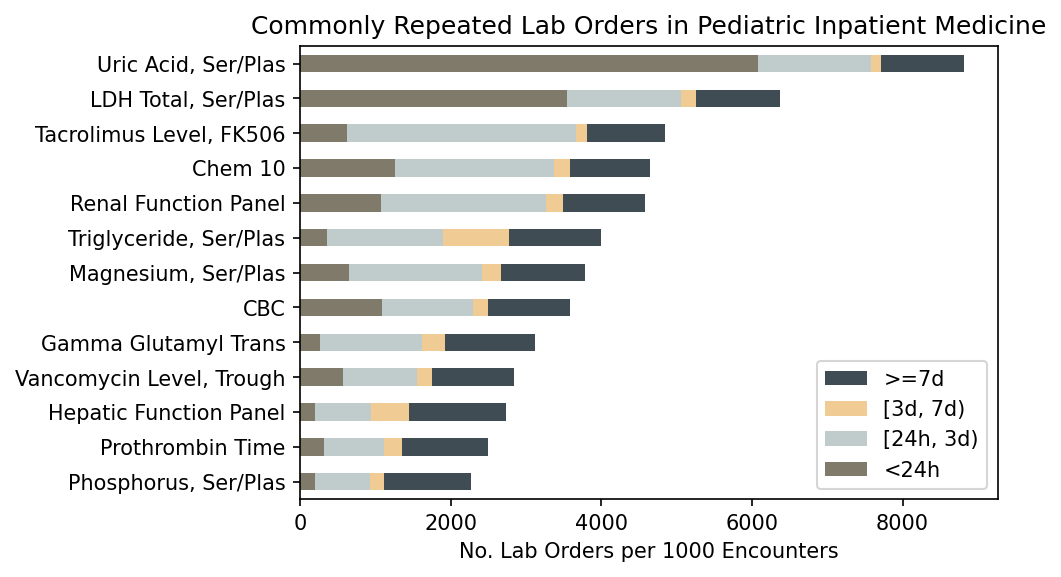

In [17]:
# labdtq = pd.read_csv('data/labdtq.csv', index_col=0)
ax1 = labdtq.iloc[3].plot.barh(color='#404c54');
labdtq.iloc[2].plot.barh(ax=ax1, color='#f0cc94');
labdtq.iloc[1].plot.barh(ax=ax1, color='#c0cccc');
labdtq.iloc[0].plot.barh(ax=ax1, color='#807A6B');
ax1.legend();
ax1.invert_yaxis();
ax1.set_title('Commonly Repeated Lab Orders in Pediatric Inpatient Medicine');
ax1.set_xlabel('No. Lab Orders per 1000 Encounters');

## Lab Component Repitition

In [18]:
pd.DataFrame(lradt.base_name.value_counts()).head(15)

,base_name
PERFLAB,245407
NA,98847
K,97591
GLU,96400
CL,96365
CR,94426
BUN,92836
CA,92691
CO2,92282
AG,92270


In [19]:
labdf = lradt.loc[lradt.base_name!='PERFLAB', ['anon_id', 'pat_enc_csn_id_coded', 'base_name', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'base_name', 'order_time'])

In [20]:
baselabcounts = labdf.groupby(by='base_name').agg({'base_name': 'count', 'pat_enc_csn_id_coded': 'nunique', 'anon_id': 'nunique'}).rename(columns={'base_name': 'norders', 'pat_enc_csn_id_coded': 'nenc', 'anon_id': 'npat'}).sort_values('norders', ascending=False)
baselabcounts['per_enc'] = baselabcounts.norders/baselabcounts.nenc
baselabcounts.loc[baselabcounts.nenc>500].sort_values('per_enc', ascending=False).head(30)

,norders,nenc,npat,per_enc
base_name,,,,
URIC,10288,1520,1127,6.768421
LDH,9826,1813,1289,5.419746
FK506,13359,2493,781,5.358604
PHOS,81814,15443,6760,5.297805
MG,77804,15028,6436,5.177269
NA,98847,19182,8991,5.153112
PHCAI,3680,720,467,5.111111
K,97591,19123,8956,5.103331
MTX,4822,953,205,5.059811


/var/folders/qs/2zlxwwld4898377zg9fx8wqh0000gq/T/ipykernel_13872/3701289749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'] = pd.NaT
/var/folders/qs/2zlxwwld4898377zg9fx8wqh0000gq/T/ipykernel_13872/3701289749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'] = df.order_time - df_shift.order_time
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

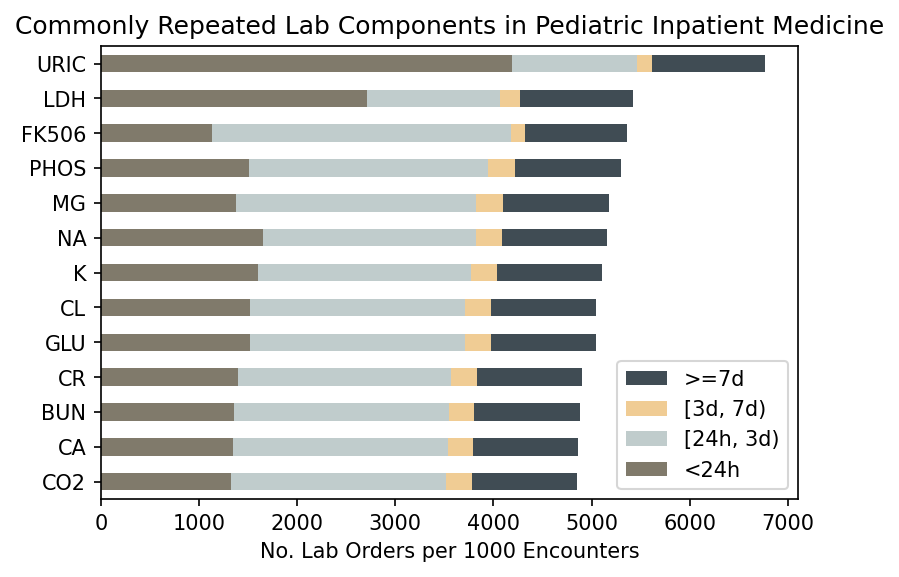

In [21]:
time_quant = [pd.Timedelta('24H'), pd.Timedelta('3D'), pd.Timedelta('1W')]
labdtq_idx = ['<24h', '[24h, 3d)', '[3d, 7d)', '>=7d']
baselabdtq = pd.DataFrame(index=labdtq_idx)
for basename in ['URIC', 'LDH', 'FK506', 'PHOS', 'MG', 'NA', 'K', 'CL', 'GLU', 'CR', 'BUN', 'CA', 'CO2']:
    #print('Lab: ', lab)
    df = labdf.loc[labdf.base_name==basename]
    df_shift = df.shift(1)
    df['dif'] = pd.NaT
    df['dif'] = df.order_time - df_shift.order_time
    newlabidx = (df.base_name != df_shift.base_name) | (df.pat_enc_csn_id_coded != df_shift.pat_enc_csn_id_coded)
    df.loc[newlabidx, 'dif'] = pd.NaT
    dtimes = df.dif
    p_enc = df['pat_enc_csn_id_coded'].nunique()
    dtq = []
    dtq.append(sum(dtimes < pd.Timedelta('24H')))
    dtq.append(sum( (dtimes < pd.Timedelta('3D')) & (dtimes >= pd.Timedelta('24H')) ))
    dtq.append(sum( (dtimes < pd.Timedelta('7D')) & (dtimes >= pd.Timedelta('3D')) ))
    dtq.append(sum((dtimes >= pd.Timedelta('7D')) | (dtimes.isnull()) ))
    #print('[0, 24h):\t', dtq[0])
    #print('[24h, 3d)]:\t', dtq[1])
    #print('[3d, 7d)]:\t', dtq[2])
    #print('[7d, inf)]:\t', dtq[3])
    baselabdtq[basename] = np.cumsum(dtq)/p_enc*1000
ax1 = baselabdtq.iloc[3].plot.barh(color='#404c54');
baselabdtq.iloc[2].plot.barh(ax=ax1, color='#f0cc94');
baselabdtq.iloc[1].plot.barh(ax=ax1, color='#c0cccc');
baselabdtq.iloc[0].plot.barh(ax=ax1, color='#807A6B');
ax1.legend();
ax1.invert_yaxis();
ax1.set_title('Commonly Repeated Lab Components in Pediatric Inpatient Medicine');
ax1.set_xlabel('No. Lab Orders per 1000 Encounters');

## Lab Component Stability

In [27]:
def windowedLabCounts(LABNAME, LOWER, UPPER):
    lrdf = lradt.loc[(lradt.base_name==LABNAME) & (lradt.ord_num_value < UPPER) & (lradt.ord_num_value > LOWER)].sort_values(by=['pat_enc_csn_id_coded', 'result_time']).reset_index()
    lrdf['result'] = 'N'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='High') | (lrdf.result_flag=='High Panic')), 'result'] = 'H'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='Low') | (lrdf.result_flag=='Low Panic')), 'result'] = 'L'
    lrdf['normal'] = (lrdf.result=='N')
    print('LAB:', LABNAME)
    print(lrdf.normal.value_counts())

    lrdf['preceding']=0
    for enc in lrdf.pat_enc_csn_id_coded.unique():
        enc_idx = (lrdf.pat_enc_csn_id_coded==enc)
        df = lrdf.loc[enc_idx, ['result_time', 'normal']]
        rownum = 0
        for (idx, row) in df.iterrows():
            if rownum>0:
                rtime = row.result_time
                dfslice = df.loc[(df.result_time <= rtime) & (df.result_time > rtime - pd.Timedelta('7D'))]
                if dfslice.shift().loc[idx, 'normal']==True:
                    y = dfslice.shift().normal
                    prec = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
                    lrdf.loc[idx, 'preceding'] = prec.values[-1]
            else:
                lrdf.loc[idx, 'preceding'] = -1
            rownum = rownum + 1
    return lrdf

In [28]:
nadf = windowedLabCounts('NA', 0, 200);
kdf = windowedLabCounts('K', 0, 8);
mgdf = windowedLabCounts('MG', 0, 10);
phosdf = windowedLabCounts('PHOS', 0, 50);
crdf = windowedLabCounts('CR', 0, 20);
wbcdf = windowedLabCounts('WBC', 0, 100000);
hgbdf = windowedLabCounts('HGB', 0, 30);
pltdf = windowedLabCounts('PLT', 0, 500000)
tacdf = windowedLabCounts('FK506', 0, 100)
uricdf = windowedLabCounts('URIC', 0, 1000)
ldhdf = windowedLabCounts('LDH', 0, 10000)

labs_df_dict = {
    'NA': nadf,
    'K': kdf,
    'MG': mgdf,
    'PHOS': phosdf,
    'CR': crdf,
    'WBC': wbcdf,
    'HGB': hgbdf,
    'PLT': pltdf,
    'TAC': tacdf,
    'URIC': uricdf,
    'LDH': ldhdf
}

LAB: NA
True     78051
False    20716
Name: normal, dtype: int64
LAB: K
True     79444
False    17936
Name: normal, dtype: int64
LAB: MG
True     53318
False    24433
Name: normal, dtype: int64
LAB: PHOS
True     55067
False    26681
Name: normal, dtype: int64
LAB: CR
True     69513
False    24501
Name: normal, dtype: int64
LAB: WBC
False    33309
True     23556
Name: normal, dtype: int64
LAB: HGB
False    52284
True     10524
Name: normal, dtype: int64
LAB: PLT
False    33207
True     24210
Name: normal, dtype: int64
LAB: FK506
True     11103
False      873
Name: normal, dtype: int64
LAB: URIC
True     5594
False    1200
Name: normal, dtype: int64
LAB: LDH
False    4829
True     4662
Name: normal, dtype: int64


In [89]:
nastab = nadf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
kstab = kdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
mgstab = mgdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
phosstab = phosdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
crstab = crdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
wbcstab = wbcdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
hgbstab = hgbdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
pltstab = pltdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
tacstab = tacdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
uricstab = uricdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]
ldhstab = ldhdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8]

labstab = pd.DataFrame()
labstab['Sodium'] = nastab['normal']['sum']/nastab['normal']['count'].astype('float')
labstab['Potassium'] = kstab['normal']['sum']/kstab['normal']['count'].astype('float')
labstab['Creatinine'] = crstab['normal']['sum']/crstab['normal']['count'].astype('float')
labstab['Magnesium']  = mgstab['normal']['sum']/mgstab['normal']['count'].astype('float')
labstab['Phosphorus'] = phosstab['normal']['sum']/phosstab['normal']['count'].astype('float')
labstab['White Cells'] = wbcstab['normal']['sum']/wbcstab['normal']['count'].astype('float')
labstab['Hemoglobin'] = hgbstab['normal']['sum']/hgbstab['normal']['count'].astype('float')
labstab['Platelets'] = pltstab['normal']['sum']/pltstab['normal']['count'].astype('float')
labstab['Tacrolimus'] = tacstab['normal']['sum']/tacstab['normal']['count'].astype('float')
labstab['Uric Acid'] = uricstab['normal']['sum']/uricstab['normal']['count'].astype('float')
labstab['LDH'] = ldhstab['normal']['sum']/ldhstab['normal']['count'].astype('float')

labstabcnts = pd.DataFrame()
labstabcnts['Sodium'] = nastab['normal']['count']
labstabcnts['Potassium'] = kstab['normal']['count']
labstabcnts['Creatinine'] = crstab['normal']['count']
labstabcnts['Magnesium']  = mgstab['normal']['count']
labstabcnts['Phosphorus'] = phosstab['normal']['count']
labstabcnts['White Cells'] = wbcstab['normal']['count']
labstabcnts['Hemoglobin'] = hgbstab['normal']['count']
labstabcnts['Platelets'] = pltstab['normal']['count']
labstabcnts['Tacrolimus'] = tacstab['normal']['count']
labstabcnts['Uric Acid'] = uricstab['normal']['count']
labstabcnts['LDH'] = ldhstab['normal']['count']
labstabcnts = pd.melt(labstabcnts.transpose().reset_index(), id_vars='index').rename(columns={'index':'lab'})

labstab.to_csv('data/labstab.csv')
labstabcnts.to_csv('data/labstabcnts.csv')

In [111]:
lab_name_dict = {
    'NA': 'Sodium',
    'K': 'Potassium',
    'MG': 'Magnesium',
    'PHOS': 'Phosphorus',
    'CR': 'Creatinine',
    'WBC': 'White Blood Cells',
    'HGB': 'Hemoglobin',
    'PLT': 'Platelets',
    'TAC': 'Tacrolimus',
    'URIC': 'Uric Acid',
    'LDH': 'LDH'
}
labstabdf = pd.DataFrame(columns=['base_name', 'lab_name', 'preceding_streak', 'normal_count', 'total_count', 'normal_prop'])
for base_name in labs_df_dict.keys():
    labdf_temp = labs_df_dict[base_name].groupby('preceding').agg({'normal' : ['sum', 'count']})[0:8].reset_index()
    baselabdf = pd.DataFrame()
    baselabdf['preceding_streak'] = labdf_temp['preceding']
    baselabdf['base_name'] = base_name
    baselabdf['lab_name'] = lab_name_dict[base_name]
    baselabdf['normal_count'] = labdf_temp['normal']['sum']
    baselabdf['total_count'] = labdf_temp['normal']['count']
    baselabdf['normal_prop'] = baselabdf['normal_count'].astype(float)/baselabdf['total_count'].astype(float)
    labstabdf = labstabdf.append(baselabdf)
labstabdf.to_csv('data/labstab_melted.csv')
# This is in melted format

In [94]:
def plotLabStab(df, ndays, ax = None, subset=False, labs=['']):
    df = df[1:ndays+2]
    if subset:
        df = df[labs]
    sns.set_style("white");
    if ax is None:
        ax = sns.lineplot(data = df, markers=True);
    else:
        sns.lineplot(data = df, markers=True, ax = ax);
    ax.set_xlabel('Consecutive Normal Results in Past 7 Days Preceding Lab');
    ax.set_xlim(-0.25, ndays+0.25)
    ax.set_xticks(np.arange(ndays+1))
    ax.set_ylabel('Proportion Normal Results');
    ax.set_title('Stability for Common Inpatient Laboratory Studies');
    ax.set_ylim(0, 1.0);
    return ax

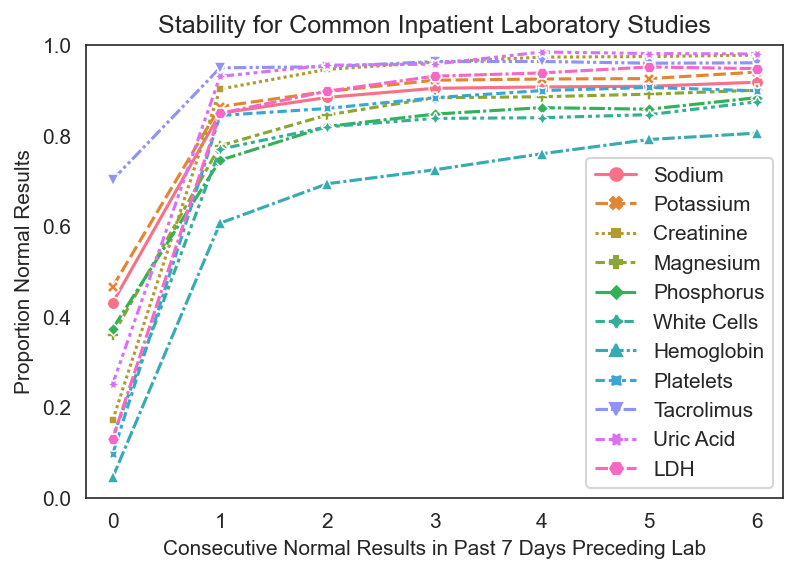

In [95]:
plotLabStab(labstab, 6);

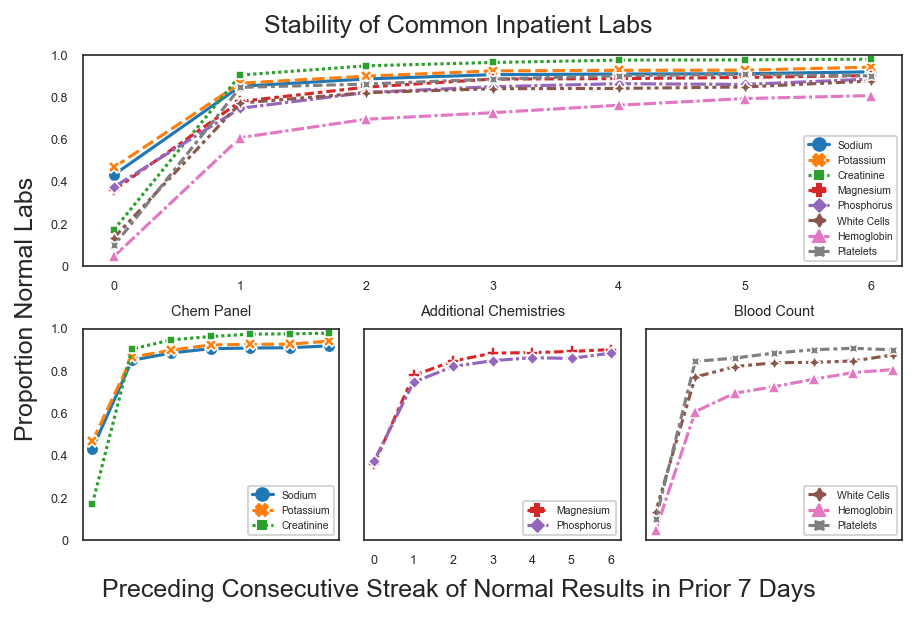

In [102]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)
axes = []
# create sub plots as grid
axes.append(fig.add_subplot(gs[0, :]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1], sharey=axes[1]))
axes.append(fig.add_subplot(gs[1, 2], sharey=axes[1]))

reglabs = ['Sodium', 'Potassium', 'Creatinine', 'Magnesium', 'Phosphorus', 
          'White Cells', 'Hemoglobin', 'Platelets']
chem1 = ['Sodium', 'Potassium', 'Creatinine']
chem2 = ['Magnesium', 'Phosphorus']
cbc = ['White Cells', 'Hemoglobin', 'Platelets']
cmap = sns.color_palette()

STREAK = 7
sns.set_style("white");
dash_list = sns._core.unique_dashes(8);
marker_list = sns._core.unique_markers(8)
sns.lineplot(data=labstab[reglabs][1:STREAK+1], ax = axes[0],
             palette = cmap[0:8], dashes=dash_list, markers=marker_list);
sns.lineplot(data=labstab[chem1][1:STREAK+1], ax=axes[1],
             palette = cmap[0:3], dashes=dash_list[0:3], markers=marker_list[0:3])
sns.lineplot(data=labstab[chem2][1:STREAK+1], ax=axes[2], 
             palette = cmap[3:5], dashes=dash_list[3:5], markers=marker_list[3:5])
sns.lineplot(data=labstab[cbc][1:STREAK+1], ax=axes[3], 
             palette = cmap[5:8], dashes=dash_list[5:8], markers=marker_list[5:8])


# plotLabStab(labstab, 6, ax=axes[0]);
# plotLabStab(labstab, 6, ax = axes[1], subset = True, labs = ['Sodium', 'Potassium', 'Creatinine']);
# plotLabStab(labstab, 6, ax = axes[2], subset = True, labs = ['Magnesium', 'Phosphorus']);
# plotLabStab(labstab, 6, ax = axes[3], subset = True, labs = ['White Cells', 'Hemoglobin', 'Platelets']);

for ax in axes:
    ax.set_xlim(-0.25, STREAK-0.75);
    ax.set_ylim(0, 1);
    ax.set_xticks(np.arange(STREAK));
    ax.set_xticklabels(labels=np.arange(STREAK), fontsize=6);
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=6);
    ax.set_ylabel('');
    ax.set_xlabel('');
    ax.set_title('');
    ax.legend(fontsize=5, loc=4);
    
#axes[0].set_title('All')
axes[1].set_title('Chem Panel', fontsize=7);
axes[2].set_title('Additional Chemistries', fontsize=7);
axes[3].set_title('Blood Count', fontsize=7);
plt.setp(axes[2].get_yticklabels(), visible=False)
plt.setp(axes[3].get_yticklabels(), visible=False)
plt.setp(axes[1].get_xticklabels(), visible=False)
plt.setp(axes[3].get_xticklabels(), visible=False)
axes[0].xaxis.labelpad = 10000;

fig.supylabel('Proportion Normal Labs');
fig.supxlabel('Preceding Consecutive Streak of Normal Results in Prior 7 Days');
fig.suptitle('Stability of Common Inpatient Labs');